In [8]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.data_utils import *
from src.lstm import LSTMModel
from src.training_utils import *
from src.tuning_utils import *
import optuna

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# define data directory
data_dir = '../data/'

In [10]:
# load data
data = load_data(data_dir)

# split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data)

Number of samples: 13388
--------------------
Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)
--------------------
X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

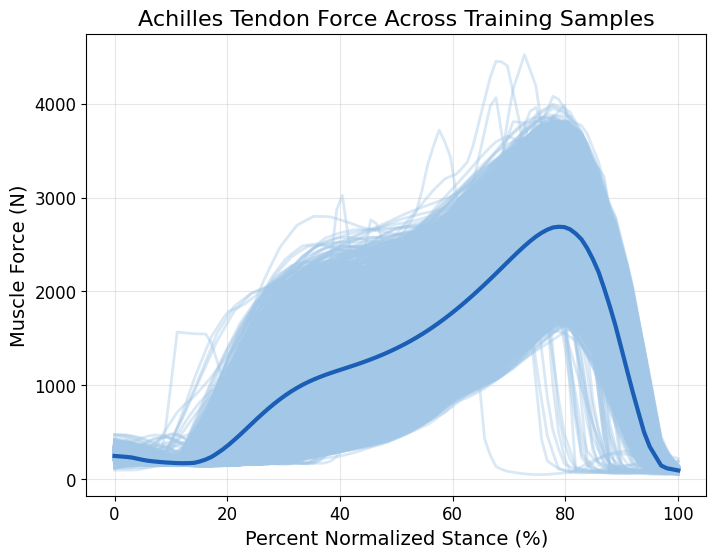

In [11]:
# plot data to double check
plot_achilles_force(y_train)

In [12]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [13]:
# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [14]:
def objective(trial, train_dataset, val_dataset, device):
    """
    Optuna objective function for hyperparameter optimization.
    
    Args:
        trial: Optuna trial object.
        train_dataset: Training dataset.
        val_dataset: Validation dataset.
        device: Device to use for training.
    
    Returns:
        float: Best validation loss for this trial.
    """
    # Sample hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 3, step=1)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    regularization = trial.suggest_float('regularization', 1e-5, 1e-2, log=True)
    
    # Prepare model parameters
    model_params = {
        'input_size': 3,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'output_size': 9
    }
    
    # Train and evaluate
    best_val_loss, _ = train_eval_optuna(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        model_class=LSTMModel,
        model_params=model_params,
        learning_rate=learning_rate,
        batch_size=batch_size,
        regularization=regularization,
        device=device,
        num_epochs=10,
        patience=10,
        verbose=False
    )
    
    return best_val_loss


# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: objective(trial, train_dataset, val_dataset, device),
    n_trials=10
)

print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

[I 2025-11-10 21:27:26,495] A new study created in memory with name: no-name-2f6a16ea-1019-45ea-955e-264e119f16b5
[I 2025-11-10 21:43:49,160] Trial 0 finished with value: 264188.4995795964 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 2.4329097701879986e-05, 'batch_size': 32, 'regularization': 2.1704031215579584e-05}. Best is trial 0 with value: 264188.4995795964.
[I 2025-11-10 22:08:47,173] Trial 1 finished with value: 91254.89614863602 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 0.006825413498444279, 'batch_size': 64, 'regularization': 4.108206616193263e-05}. Best is trial 1 with value: 91254.89614863602.
[I 2025-11-10 22:15:11,344] Trial 2 finished with value: 263205.50913210015 and parameters: {'hidden_size': 64, 'num_layers': 3, 'learning_rate': 0.00012407777021414731, 'batch_size': 64, 'regularization': 0.0016134344116796896}. Best is trial 1 with value: 91254.89614863602.
[I 2025-11-10 22:19:48,622] Trial 3 finished with value:

Best hyperparameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 0.006825413498444279, 'batch_size': 64, 'regularization': 4.108206616193263e-05}
Best validation loss: 91254.89614863602


In [ ]:
# Train the final model with the best hyperparameters
final_val_loss, best_model = train_eval(train_dataset, val_dataset,
                                        hidden_size=best_params['hidden_size'],
                                        num_layers=best_params['num_layers'],
                                        dropout_rate=best_params['dropout_rate'],
                                        learning_rate=best_params['learning_rate'],
                                        batch_size=best_params['batch_size'],
                                        regularization=best_params['regularization'],
                                        num_epochs=1000)

In [ ]:
torch.save(best_model.state_dict(), '..\models\lstm.pth')

In [ ]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# set model to evaluation mode
best_model.eval()

# initialize test loss
test_loss = 0

criterion = nn.MSELoss()

# no need to calculate gradients during testing
with torch.no_grad():
    # forward pass
    test_outputs = best_model(X_test_tensor)
    
    # calculate loss
    test_loss = criterion(test_outputs, y_test_tensor).item()

# print test loss
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
# Move predictions and ground truth to CPU for visualization
pred = test_outputs[0].cpu().numpy()  # Shape: (seq_length, 9)
true = y_test_tensor[0].cpu().numpy()      # Shape: (seq_length, 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i in range(9):
    axes[i].plot(perc_stance, true[:, i], label="True")
    axes[i].plot(perc_stance, pred[:, i], label="Predicted", linestyle='dashed')
    axes[i].set_title(muscle_dict[i])
    axes[i].set_xlabel("Percent Normalized Stance (%)")
    axes[i].set_ylabel("Muscle Force (N)")
    axes[i].legend()

plt.tight_layout()
plt.show()